# Introduction to Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For our modeling steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss

# For demonstrative pruposes
from scipy.special import logit, expit

# Objectives

- Describe conceptually the need to move beyond linear regression
- Explain the form of logistic regression

[Wikipedia](https://en.wikipedia.org/wiki/Generalized_linear_model) has a nice description of the need to move beyond linear regression for certain sorts of modeling problems.

# Classification

Categorizing compared to regression

## Classic example is image classification: dog or cat? 

![Dog wearing knitted cat hat](images/dog_or_cat.jpg)

> **WARNING**
>
> This doesn't refer to the _degree_ of classification but focuses on how likely they are to be correctly classified (subtle)
> 
> _This email is more spammy than the other, but they're both spam_

## Classification in Data Science

**Classification techniques** are an essential part of machine learning and data mining applications. Most problems in Data Science are classification problems. 

There are lots of classification algorithms that are available, but we'll focus on logistic regression.

We shall focus on binary classification problems, to which logistic regression most immediately applies. Other classification problems handle the cases where multiple classes are present in the target variable.

# Predicting a Categorical Response

Here we have a dataset about glass. Information [here](https://archive.ics.uci.edu/ml/datasets/glass+identification).

## Preparing Data

In [2]:
# glass identification dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
col_names = ['id','ri','na','mg','al','si','k','ca','ba','fe','glass_type']
glass = pd.read_csv(url, names=col_names, index_col='id')
glass.sort_values('al', inplace=True)
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type
id,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1


In [3]:
# types 1, 2, 3 are window glass
# types 5, 6, 7 are household glass
glass['household'] = glass['glass_type'].map({1:0, 2:0, 3:0, 5:1, 6:1, 7:1})
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,household
id,,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1,0
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6,1
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1,0


In [4]:
glass['household'].value_counts()

0    163
1     51
Name: household, dtype: int64

Let's change our task, so that we're predicting **household** using **al**. Let's visualize the relationship to figure out how to do this:

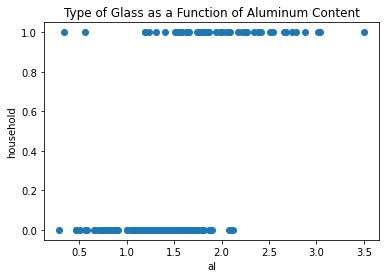

In [5]:
fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.set_xlabel('al')
ax.set_ylabel('household')
ax.set_title('Type of Glass as a Function of Aluminum Content');

In [6]:
glass.corr()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,household
ri,1.000000,-0.191885,-0.122274,-0.407326,-0.542052,-0.289833,0.810403,-0.000386,0.143010,-0.164237,-0.134327
na,-0.191885,1.000000,-0.273732,0.156794,-0.069809,-0.266087,-0.275442,0.326603,-0.241346,0.502898,0.452336
mg,-0.122274,-0.273732,1.000000,-0.481799,-0.165927,0.005396,-0.443750,-0.492262,0.083060,-0.744993,-0.758289
al,-0.407326,0.156794,-0.481799,1.000000,-0.005524,0.325958,-0.259592,0.479404,-0.074402,0.598829,0.585928
si,-0.542052,-0.069809,-0.165927,-0.005524,1.000000,-0.193331,-0.208732,-0.102151,-0.094201,0.151565,0.148072
k,-0.289833,-0.266087,0.005396,0.325958,-0.193331,1.000000,-0.317836,-0.042618,-0.007719,-0.010054,0.053774
ca,0.810403,-0.275442,-0.443750,-0.259592,-0.208732,-0.317836,1.000000,-0.112841,0.124968,0.000952,0.040670
ba,-0.000386,0.326603,-0.492262,0.479404,-0.102151,-0.042618,-0.112841,1.000000,-0.058692,0.575161,0.523403
fe,0.143010,-0.241346,0.083060,-0.074402,-0.094201,-0.007719,0.124968,-0.058692,1.000000,-0.188278,-0.194903
glass_type,-0.164237,0.502898,-0.744993,0.598829,0.151565,-0.010054,0.000952,0.575161,-0.188278,1.000000,0.941680


## Using a Regression Line

Let's draw a **regression line**, like we did before:

In [7]:
# fit a linear regression model and store the predictions

linreg = LinearRegression()
feature_cols = ['al']
X = glass[feature_cols]
y = glass.household
linreg.fit(X, y)
glass['household_pred'] = linreg.predict(X)

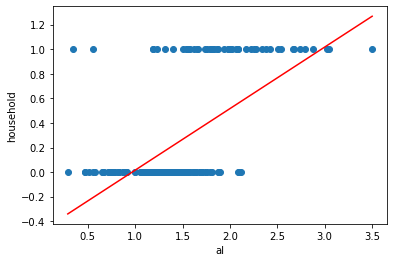

In [8]:
# scatter plot that includes the regression line

fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

> What are some issues with this graph?

-

## Interpreting Our Predictions

If **al=3**, what class do we predict for household? 

If **al=1.5**, what class do we predict for household? 

We predict the 0 class for **lower** values of al, and the 1 class for **higher** values of al. What's our cutoff value? Around **al=2**, because that's where the linear regression line crosses the midpoint between predicting class 0 and class 1.

Therefore, we'll say that if **household_pred >= 0.5**, we predict a class of **1**, else we predict a class of **0**.

# Logistic Regression

Logistic regression can do what we just did.

The strategy now is to *generalize* the notion of linear regression; linear regression as we've known it will become a special case. In particular, we'll keep the idea of the regression best-fit line, but now **we'll allow the model to make predictions through some (non-trivial) transformation of the linear predictor**.

Let's say we've constructed our best-fit line, i.e. our linear predictor, $\hat{L} = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$.

Consider the following transformation: <br/>
$\large\hat{y} = \Large\frac{1}{1 + e^{-\hat{L}}} \large= \Large\frac{1}{1 + e^{-(\beta_0 + ... + \beta_nx_n)}}$. This is called the **sigmoid function**.

We're imagining that $\hat{L}$ can take any values between $-\infty$ and $\infty$.

$\large\rightarrow$ But what values can $\hat{y}$ take? What does this function even look like?

In [ ]:
# Let's plot this function here:

X = np.linspace(-10, 10, 300)
Y = 1 / (1 + np.exp(-X))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(X, Y, 'r');

## Interpretation

This function squeezes our predictions between 0 and 1. And that's why it's so useful for **binary classification problems**.

Suppose I'm building a model to predict whether a plant is poisonous or not, based perhaps on certain biological features of its leaves. I'll let '1' indicate a poisonous plant and '0' indicate a non-poisonous plant.

Now I'm forcing my predictions to be between 0 and 1, so suppose for test plant $P$ I get some value like 0.19.

I can naturally understand this as **the probability that $P$ is poisonous**.

If I truly want a binary prediction, I can simply round my score appropriately.

# Fitting Logistic Regression

## The Logit Function

We just expressed the form of logistic regression in terms of the sigmoid function: **Our model's predictions ($\hat{y}$) are not now identical with the values of the best-fit line but rather with the outputs of the sigmoid function, with those best-fit values passed as input.**

But we can also describe the best-fit line as a function of $\hat{y}$, by applying the **inverse of the sigmoid function** to both sides. This inverse function is called the ***logit* function**:

$ln(\frac{y}{1-y}) = \hat{L} = \beta_0+\beta_1x_1 +...+\beta_nx_n$.

This fraction, $\frac{y}{1-y}$, is the **odds ratio** of y. More on this soon.

Let's try applying the logit function to our target and then fitting a linear regression to that. Since the model will be trained not on whether the glass is household but rather on *the logit of this label*, it will also make predictions of the logit of that label. But we can simply apply the sigmoid function to the model's output to get its predictions of whether the glass is household.

We can't use the target as is, because the logit of 1 is $\infty$ and the logit of 0 is $-\infty$.

In [ ]:
glass['household'].unique()

In [ ]:
logit(glass['household']).unique()

So we'll make a small adjustment:

In [ ]:
target_approx = np.where(glass['household'] == 0, 1e-9, 1-1e-9)

In [ ]:
target_approx

In [ ]:
logit(target_approx)

In [ ]:
line_to_logit = LinearRegression()

X = glass[['al']]
y = logit(target_approx)

line_to_logit.fit(X, y)

In [ ]:
logit_predictions = line_to_logit.predict(X)

In [ ]:
fig, ax = plt.subplots()

final_preds = expit(line_to_logit.predict(X))
ax.scatter(X, glass['household'])
ax.plot(X, final_preds, 'm');

In [ ]:
fig, ax = plt.subplots()

final_preds = expit(line_to_logit.predict(X))
ax.scatter(X, logit_predictions)
#ax.plot(X, final_preds, 'm');

## `sklearn.linear_model.LogisticRegression()`

In general, we should always scale our data when using this class. Scaling is always important for models that include regularization, and scikit-learn's `LogisticRegression()` objects have regularization by default.

Here we've forgone the scaling since we only have a single predictor.

In [ ]:
feature_cols

In [ ]:
X

In [ ]:
y = glass['household']

In [ ]:
# fit a logistic regression model and store the class predictions

logreg = LogisticRegression(random_state=42)
logreg.fit(X, y)

In [ ]:
glass['household_pred_class'] = logreg.predict(X)
glass.head()

In [ ]:
# plot the class predictions

fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred_class, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

## `.predict()` vs. `.predict_proba()`

Let's checkout some specific examples to make predictions with. We'll use both `predict()` and `predict_proba()`.

In [ ]:
glass.al

In [ ]:
glass['al'][22].reshape(1, -1)

In [ ]:
# examine some example predictions

print(logreg.predict(glass['al'][22].reshape(1, -1)))
print(logreg.predict(glass['al'][185].reshape(1, -1)))
print(logreg.predict(glass['al'][164].reshape(1, -1)))
print('\n')
print(logreg.predict_proba(glass['al'][22].reshape(1, -1))[0])
print(logreg.predict_proba(glass['al'][185].reshape(1, -1))[0])
print(logreg.predict_proba(glass['al'][164].reshape(1, -1))[0])
first_row = glass['al'][22].reshape(1, -1)

In [ ]:
# store the predicted probabilites of class 1
glass['household_pred_prob'] = logreg.predict_proba(X)[:, 1]

In [ ]:
glass['household_pred_prob']

In [ ]:
# plot the predicted probabilities
fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred_prob, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

In [ ]:
def manual_thres(probs):
    new_class_pred = []
    for value in probs:
        if value >= .3:
            new_class_pred.append(1)
        else:
            new_class_pred.append(0)
    return new_class_pred

In [ ]:
new_class = manual_thres(glass['household_pred_prob'])
new_class

In [ ]:
original_preds = logreg.predict(X)

In [ ]:
original_preds == new_class

The first column indicates the predicted probability of **class 0**, and the second column indicates the predicted probability of **class 1**.

In [ ]:
log_loss(glass['household'], logreg.predict_proba(X))

In [ ]:
log_loss(y, glass['household_pred_prob'])

The above is a pretty good score. A baseline classifier that is fit on data with equal numbers of data points in the two target classes should be right about 50% of the time, and the log loss for such a classifier would be $-ln(0.5) = 0.693$.

In [ ]:
-np.log(0.5)

## Level Up: Odds

There are other ways to squeeze the results of a linear regression into the set (0, 1).

But the ratio $\frac{p}{1-p}$ represents the *odds* of some event, where $p$ is the probability of the event.

$$probability = \frac {one\ outcome} {all\ outcomes}$$

$$odds = \frac {one\ outcome} {all\ other\ outcomes}$$

Examples:

- Dice roll of 1: probability = 1/6, odds = 1/5
- Even dice roll: probability = 3/6, odds = 3/3 = 1
- Dice roll less than 5: probability = 4/6, odds = 4/2 = 2

$$odds = \frac {probability} {1 - probability}$$

$$probability = \frac {odds} {1 + odds}$$

And so the logit function represents the **log-odds** of success (y=1).